In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Importing keras from tensor flow to use Google Colab's TPU (To accelerate training)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, SpatialDropout1D, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Importing libraries required for cleaning text
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

# Importing for tokenizing our reviews
from keras.preprocessing.text import Tokenizer

# Importing for Padding our text to make all reviews have equal length
from keras.preprocessing.sequence import pad_sequences

In [2]:
# To import data file from your google drive.
from google.colab import drive
drive.mount('/content/drive')
#path = 'gdrive/My Drive/Colab Notebooks/data.csv'  # gdrive/My Drive/Folder Name/File Name.csv

Mounted at /content/drive


In [3]:
# Reading data from file into a Pandas DataFrame
df=pd.read_csv('/content/drive/MyDrive/Thesis/clean_data_large.txt', sep ='<',header = 0)
df.head()

,stars,useful,funny,cool,text,stars_str,txt_len
0,1,1,0,0,"Foods not fresh, taste is mediocre and for the...",1,183
1,1,3,0,0,"Hostess are totally incompetent, they told me ...",1,206
2,1,4,4,0,Do not bring your car here! Not only do they ...,1,380
3,1,1,0,0,Strike 1. Got a suit back with heavy chemical ...,1,779
4,1,1,2,1,This is like Horror Nights not at Universal St...,1,170


In [4]:
# Dropping unecessary columns.
df = df[['text', 'stars']]
df.describe(include = 'all')

,text,stars
count,350000,350000.000000
unique,350000,NaN
top,"Foods not fresh, taste is mediocre and for the...",NaN
freq,1,NaN
mean,NaN,3.000000
std,NaN,1.414216
min,NaN,1.000000
25%,NaN,2.000000
50%,NaN,3.000000
75%,NaN,4.000000


In [5]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Function for cleaning HTML
def clean_Html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

# Function for cleaning Punctuation/Special Characters
def clean_Punc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

# Function for cleaning Uppercase letters
def keep_Alpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

# Function for stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# Applying these functions to our DataFrame
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(clean_Html)
df['text'] = df['text'].apply(clean_Punc)
df['text'] = df['text'].apply(keep_Alpha)
df['text'] = df['text'].apply(stemming)

df.head()

,text,stars
0,food not fresh tast is mediocr and for the pri...,1
1,hostess are total incompet they told me h and ...,1
2,do not bring your car here not onli do they ch...,1
3,strike got a suit back with heavi chemic smell...,1
4,this is like horror night not at univers studi...,1


In [6]:
# Performing Tokenization
max_num_words = 10000 # Max number of the most frequents words to be used
max_len = 1000 # Max number of words in each review
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)

In [7]:
# Padding reviews to make them have equal length
x = tokenizer.texts_to_sequences(df['text'].values)
x = pad_sequences(x, maxlen=max_len)

In [8]:
# Performing OneHot Encoding of Stars
y = pd.get_dummies(data=df[['stars']], columns=['stars']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (350000, 5)


In [9]:
# Splitting dataset into Train and Test datasets in 70:30
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20,random_state = 200)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(280000, 1000) (280000, 5)
(70000, 1000) (70000, 5)


In [10]:
# Initializing Google Colab's TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    tpu_strategy = tf.distribute.get_strategy() # to use CPU and single GPU

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.64.179.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.64.179.114:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [11]:
# Enabling Google Colabs's TPU
with tpu_strategy.scope():
  # Building a GRU Model
  model=Sequential()
  model.add(Embedding(max_num_words, embedding_dim, input_length=max_len, trainable=False))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(16, activation="relu"))
  model.add(Dense(5, activation="softmax"))
  model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
 
  epochs = 50
  batch_size = 128
  # Training a GRU model on Colab's TPU
  LSTM_Model = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/50
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


1969/1969 [==============================] - 197s 96ms/step - loss: 1.4246 - accuracy: 0.3597 - val_loss: 1.3406 - val_accuracy: 0.4193
Epoch 2/50
1969/1969 [==============================] - 185s 94ms/step - loss: 1.3108 - accuracy: 0.4322 - val_loss: 1.2939 - val_accuracy: 0.4401
Epoch 3/50
1969/1969 [==============================] - 184s 94ms/step - loss: 1.2206 - accuracy: 0.4698 - val_loss: 1.1650 - val_accuracy: 0.4914
Epoch 4/50
1969/1969 [==============================] - 184s 94ms/step - loss: 1.1464 - accuracy: 0.5014 - val_loss: 1.1386 - val_accuracy: 0.5060
Epoch 5/50
1969/1969 [==============================] - 185s 94ms/step - loss: 1.1020 - accuracy: 0.5211 - val_loss: 1.1018 - val_accuracy: 0.5233
Epoch 6/50
1969/1969 [==============================] - 184s 94ms/step - loss: 1.0720 - accuracy: 0.5333 - val_loss: 1.0510 - val_accuracy: 0.5415
Epoch 7/50
1969/1969 [==============================] - 185s 94ms/step - loss: 1.0499 - accuracy: 0.5423 - val_loss: 1.0637 - val

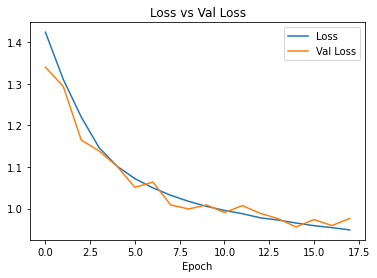

In [12]:
plt.plot(LSTM_Model.history['loss'])
plt.plot(LSTM_Model.history['val_loss'])
plt.title('Loss vs Val Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'], loc='upper right')
plt.show()

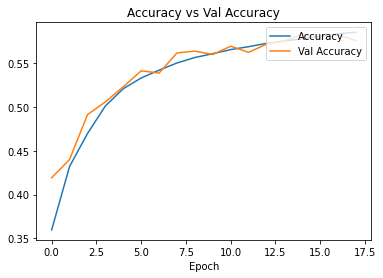

In [13]:
plt.plot(LSTM_Model.history['accuracy'])
plt.plot(LSTM_Model.history['val_accuracy'])
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'], loc='upper right')
plt.show()

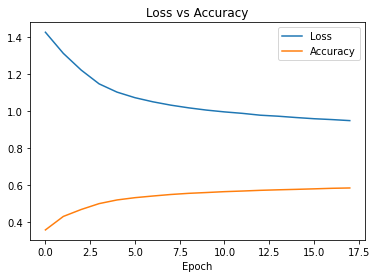

In [14]:
plt.plot(LSTM_Model.history['loss'])
plt.plot(LSTM_Model.history['accuracy'])
plt.title('Loss vs Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

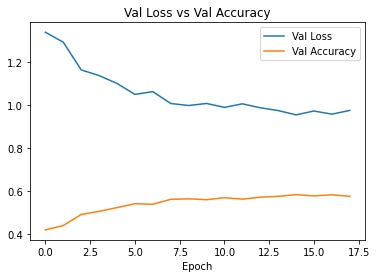

In [15]:
plt.plot(LSTM_Model.history['val_loss'])
plt.plot(LSTM_Model.history['val_accuracy'])
plt.title('Val Loss vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val Loss', 'Val Accuracy'], loc='upper right')
plt.show()

In [16]:
# Evaluting model on Test Set
test = model.evaluate(x_test,y_test)
print('For Test Set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test[0], test[1]))

2188/2188 [==============================] - 83s 38ms/step - loss: 0.9787 - accuracy: 0.5717
For Test Set
  Loss: 0.979
  Accuracy: 0.572


In [17]:
# Saving Trained Model in Google Drive 
model_path = '/content/drive/MyDrive/Thesis/LSTM/LSTM_Classification_Review_Stars_A57.2_18Epochs.h5'


In [18]:
model.save(model_path)

In [ ]:
# Loading the Trained Model
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
# Verifiying the Trained Model
test1 = loaded_model.evaluate(x_test,y_test)
print('For Test Set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test1[0], test1[1]))

3282/3282 [==============================] - 226s 69ms/step - loss: 0.9370 - accuracy: 0.5886
For Test Set
  Loss: 0.937
  Accuracy: 0.589


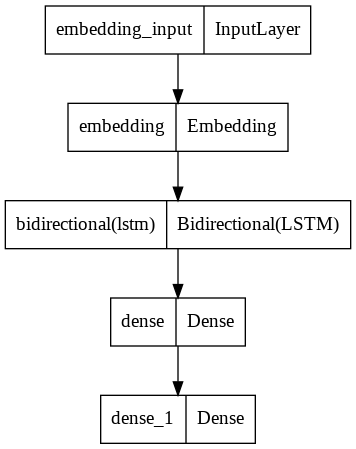

In [20]:
tf.keras.utils.plot_model(model)

Loaded model verified Successfully.